## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

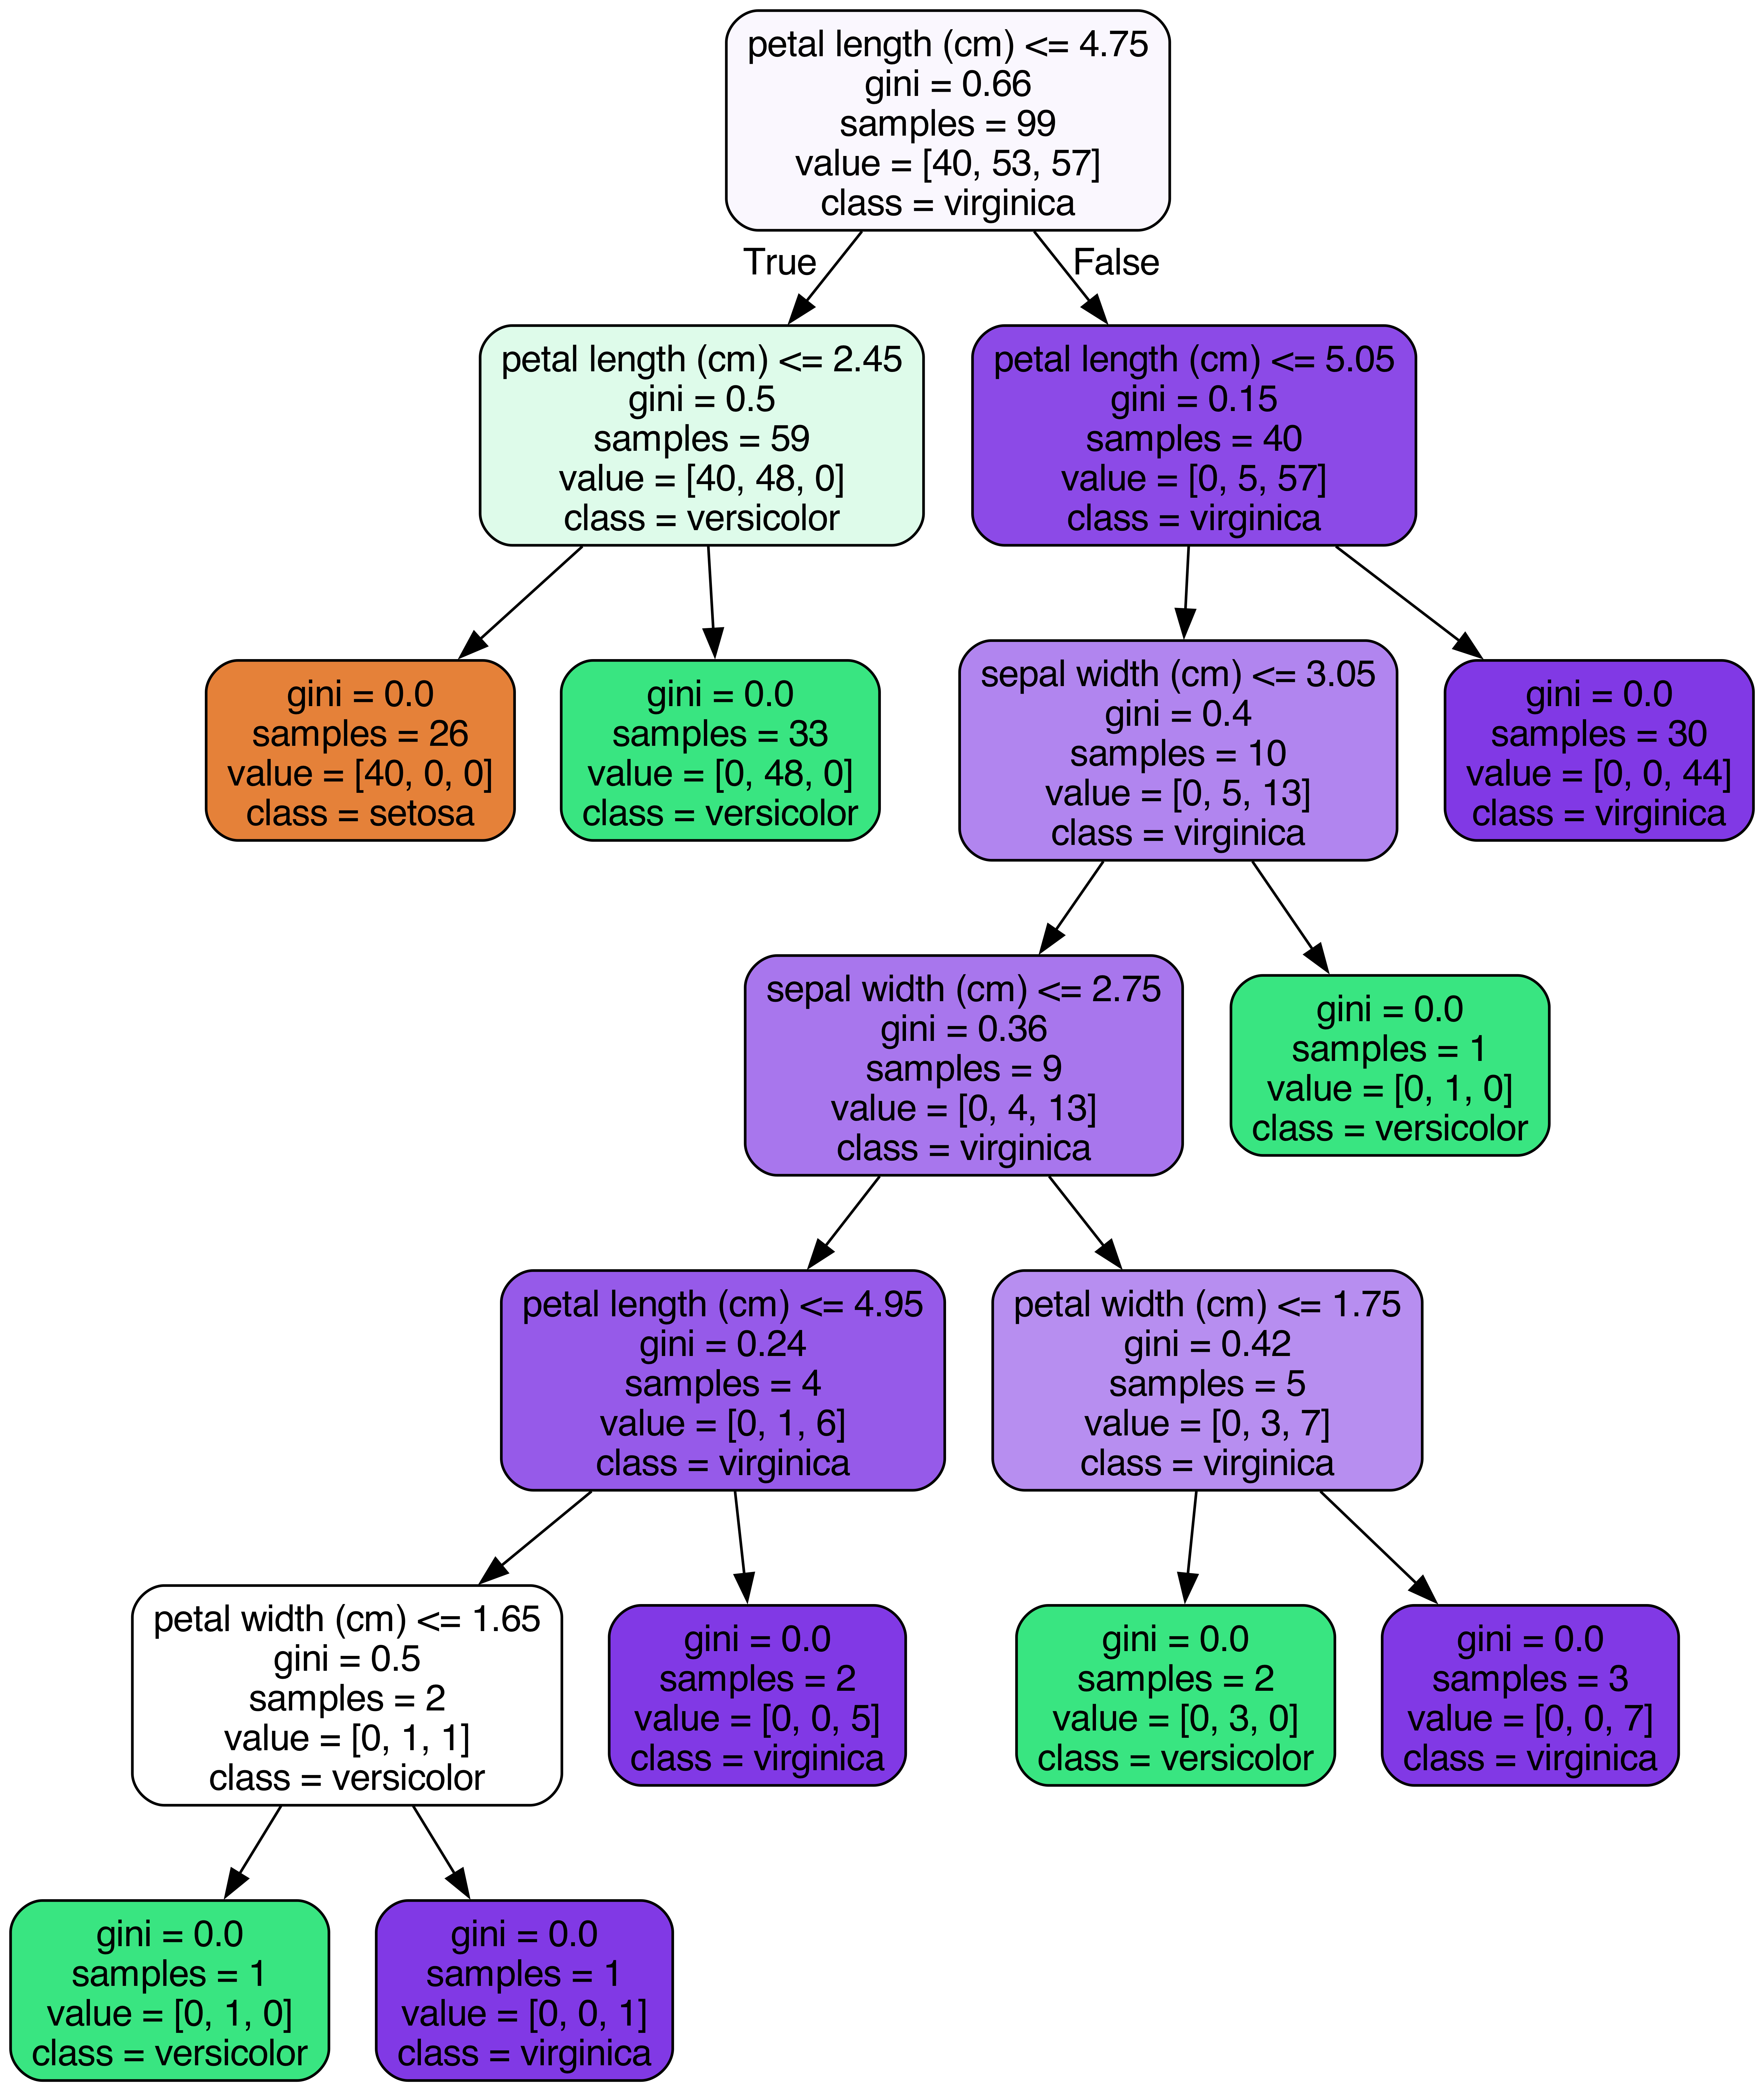

In [200]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [252]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [254]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv("../data/PatientInfo.csv")
#df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [256]:
df.shape

(2218, 18)

In [258]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [260]:
#counts of response variable values
df.state.value_counts()

state
isolated    1791
released     307
deceased      32
Name: count, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [263]:
df['age'] = 2025 - df['birth_year'] 

### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [268]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1764 non-null   float64
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

In [270]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing = missing.sort_values(by='count', ascending=False)

print(missing)

                    count          %
disease              2199  99.143372
deceased_date        2186  98.557259
infection_order      2176  98.106402
symptom_onset_date   2025  91.298467
released_date        1995  89.945897
contact_number       1807  81.469793
infected_by          1749  78.854824
infection_case       1055  47.565374
global_num            904  40.757439
birth_year            454  20.468891
age                   454  20.468891
sex                   145   6.537421
confirmed_date        141   6.357078
state                  88   3.967538
city                   65   2.930568
province                0   0.000000
country                 0   0.000000
patient_id              0   0.000000


 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [273]:
df['disease'] = df['disease'].fillna(0)

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [276]:
#df['global_num','birth_year','infection_order','infected_by','contact_number'] = df['global_num','birth_year','infection_order','infected_by','contact_number'].fillna(df.mean()) 

df['global_num'] = df['global_num'].fillna(df['global_num'].mean()) 
df['birth_year'] = df['birth_year'].fillna(df['birth_year'].mean()) 
df['infection_order'] = df['infection_order'].fillna(df['infection_order'].mean()) 
df['infected_by'] = df['infected_by'].fillna(df['infected_by'].mean()) 
df['contact_number'] = df['contact_number'].fillna(df['contact_number'].mean()) 




In [278]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing = missing.sort_values(by='count', ascending=False)

print(missing)

                    count          %
deceased_date        2186  98.557259
symptom_onset_date   2025  91.298467
released_date        1995  89.945897
infection_case       1055  47.565374
age                   454  20.468891
sex                   145   6.537421
confirmed_date        141   6.357078
state                  88   3.967538
city                   65   2.930568
disease                 0   0.000000
global_num              0   0.000000
infection_order         0   0.000000
infected_by             0   0.000000
contact_number          0   0.000000
province                0   0.000000
country                 0   0.000000
birth_year              0   0.000000
patient_id              0   0.000000


 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [281]:
#deceased date missing assume not decesased:
df['deceased_date'] = df['deceased_date'].fillna(0)


In [283]:
#For missing age we will take the average
df['age'] = df['age'].fillna(df['age'].mean()) 

In [337]:
male_count = (df['sex'] == 'male').sum()
female_count = (df['sex'] == 'female').sum()

print(male_count)
print(female_count)


899
1171


In [287]:
#About 56% of the persons infected are females and so we should impute 56% of the missing values with females.
#Although, it may be more helpful to drop the value all together becasue there is the possibility of introducing 
#potential confounds into the data. Thus we will drop those pateints.  This is good practice becasue we should
#consider this data could be used for different studies and so sex can be a major deterministic factor and we 
#do not want to made a model that is less optimal that what it would have otherwise have been. 

df = df.dropna(subset=['sex'])


In [289]:
#We will drop the patient that does not have a confirmed date:

df = df.dropna(subset=['confirmed_date'])

In [291]:
#Most Patients do not have a symptoms onset date so we will drop that column entirely and also the release date entirely

df = df.drop(columns=['symptom_onset_date', 'released_date'], inplace=False)

In [335]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing = missing.sort_values(by='count', ascending=False)

print(missing)

                 count    %
patient_id           0  0.0
global_num           0  0.0
sex                  0  0.0
birth_year           0  0.0
age                  0  0.0
country              0  0.0
province             0  0.0
city                 0  0.0
disease              0  0.0
infection_case       0  0.0
infection_order      0  0.0
infected_by          0  0.0
contact_number       0  0.0
confirmed_date       0  0.0
deceased_date        0  0.0
state                0  0.0


In [537]:
#At this point we have to consider infection case this is the mode of infection.  What is reasonable here?
#Well generally the most common mode of infection is: "contact_with_patient"
#Although there is a common one for a particular province:  For example in Daegu province a Church is the most common mode of infection
#And in the city Cheongdo-gun it is a hospital
#Otherwise it is contact with patient.  
#Although there is this other term call "etc" that is not clear what it means and may be equivalent to nan
#We have two options here drop the column entirely? 
#Or we impute according to the following rules#

#1. If the City is "Cheongdo-gun" we impute the infection_case with "Cheongdo Daenam Hospital"
df.loc[(df['city'] == 'Cheongdo-gun') & (df['infection_case'].isna()), 'infection_case'] = 'Cheongdo Daenam Hospital'

#2. If the province is "Daegu" with impute the infection_case with "Shincheonji Church"
df.loc[(df['province'] == 'Daegu') & (df['infection_case'].isna()), 'infection_case'] = 'Shincheonji Church'

#3. All other missing values are imputed with "patient_contact"
df['infection_case'] = df['infection_case'].fillna("patient contact") 

#4. All instances of "etc" are changed to "contact with patient"
df['infection_case'] = df['infection_case'].replace('etc', 'patient_contact')

df['infection_case'] = df['infection_case'].replace('patient_contact', 'contact with patient')
df['infection_case'] = df['infection_case'].replace('patient contact', 'contact with patient')

In [317]:
#There is missing "state" for 88 patients as patients are either isolated or released
#Because all the patients that have missing "State" have a confirmed_data of 3/15/20 and
#all those patients with a confirmed date a couples days before and all dates after are isolated we will 
#set teh state of these patients to isolated. 

df['state'] = df['state'].fillna('isolated') 



In [324]:
#In general cities belong to a specific province so we could just impute the most common city for the province. 

#If the province with missing cities is "Daegu" we will impute the city with "Nam-gu"
df.loc[(df['province'] == 'Daegu') & (df['city'].isna()), 'city'] = 'Nam-gu'

#If the proince with missing cities is "Gwangju" we will impute the city with "Gwangju" since "Gwamgju" is a city in South Korea
df.loc[(df['province'] == 'Gwangju') & (df['city'].isna()), 'city'] = 'Gwangju'


In [333]:
#At this point there are two patients with missing cities and we will drop them? 
df = df.dropna(subset=['city'])

In [339]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing = missing.sort_values(by='count', ascending=False)

print(missing)

                 count    %
patient_id           0  0.0
global_num           0  0.0
sex                  0  0.0
birth_year           0  0.0
age                  0  0.0
country              0  0.0
province             0  0.0
city                 0  0.0
disease              0  0.0
infection_case       0  0.0
infection_order      0  0.0
infected_by          0  0.0
contact_number       0  0.0
confirmed_date       0  0.0
deceased_date        0  0.0
state                0  0.0


 **<font color='teal'> Check for any remaining null values.</font>**

In [343]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,confirmed_date,deceased_date,state
0,1000000001,2.0,male,1964.0,61.0,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-23,0,released
1,1000000002,5.0,male,1987.0,38.0,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,2020-01-30,0,released
2,1000000003,6.0,male,1964.0,61.0,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,2020-01-30,0,released
3,1000000004,7.0,male,1991.0,34.0,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-30,0,released
4,1000000005,9.0,female,1992.0,33.0,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,2020-01-31,0,released


Remove date columns from the data.


In [353]:
#df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)
df = df.dropna(subset=['confirmed_date'])

Review the count of unique values by column.

In [355]:
print(df.nunique())

patient_id         2070
global_num         1303
sex                   2
birth_year           97
age                  97
country               4
province             17
city                130
disease               2
infection_case       15
infection_order       7
infected_by         207
contact_number       72
confirmed_date       45
deceased_date        17
state                 3
dtype: int64


Review the percent of unique values by column.

In [357]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.629469
sex                0.000966
birth_year         0.046860
age                0.046860
country            0.001932
province           0.008213
city               0.062802
disease            0.000966
infection_case     0.007246
infection_order    0.003382
infected_by        0.100000
contact_number     0.034783
confirmed_date     0.021739
deceased_date      0.008213
state              0.001449
dtype: float64


Review the range of values per column.

In [359]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2070.0,3.876049e+09,2.201403e+09,1.000000e+09,1.600000e+09,4.100000e+09,6.001000e+09,7.000000e+09
global_num,2070.0,4.667059e+03,2.287249e+03,1.000000e+00,3.946250e+03,4.664817e+03,6.154000e+03,8.717000e+03
birth_year,2070.0,1.974992e+03,1.790638e+01,1.916000e+03,1.964000e+03,1.974989e+03,1.990000e+03,2.020000e+03
age,2070.0,5.000797e+01,1.790638e+01,5.000000e+00,3.500000e+01,5.001134e+01,6.100000e+01,1.090000e+02
infection_order,2070.0,2.285852e+00,1.765489e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,2070.0,2.602094e+09,7.458127e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2070.0,2.392093e+01,3.925777e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03


### Check for duplicated rows

In [361]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,confirmed_date,deceased_date,state


Print the categorical columns and their associated levels.

In [363]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,2
1,country,4
2,province,17
3,city,130
4,disease,2
5,infection_case,15
6,confirmed_date,45
7,deceased_date,17
8,state,3


In [382]:
**<font color='teal'> Plot the correlation heat map for the features.</font


SyntaxError: invalid syntax (4231881752.py, line 1)

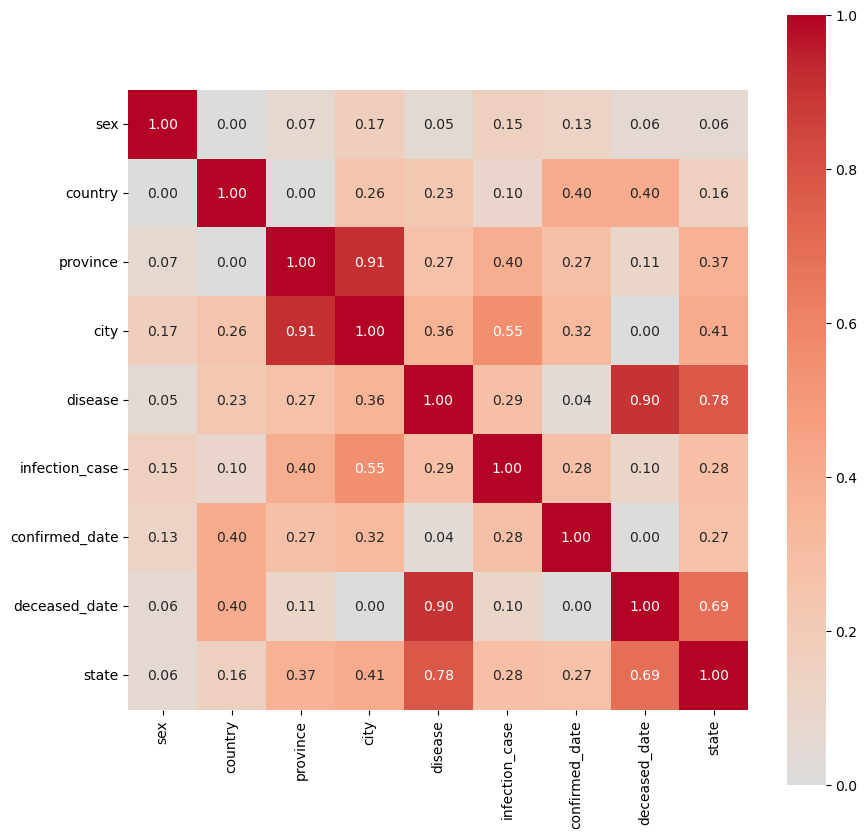

{'corr':                      sex   country  province      city   disease  \
 sex             1.000000  0.000000  0.065220  0.170455  0.048937   
 country         0.000000  1.000000  0.000000  0.256591  0.225363   
 province        0.065220  0.000000  1.000000  0.906943  0.268848   
 city            0.170455  0.256591  0.906943  1.000000  0.355260   
 disease         0.048937  0.225363  0.268848  0.355260  1.000000   
 infection_case  0.152926  0.100014  0.397432  0.548237  0.287994   
 confirmed_date  0.126760  0.398558  0.274316  0.315682  0.042714   
 deceased_date   0.059108  0.398883  0.105971  0.000000  0.903104   
 state           0.061261  0.155140  0.368605  0.413214  0.780157   
 
                 infection_case  confirmed_date  deceased_date     state  
 sex                   0.152926        0.126760       0.059108  0.061261  
 country               0.100014        0.398558       0.398883  0.155140  
 province              0.397432        0.274316       0.105971  0.368605  


In [374]:
from dython.nominal import associations

associations(dfo, figsize=(10, 10), annot=True, cmap='coolwarm')


**<font color='teal'> Plot the boxplots to check for outliers. </font>**

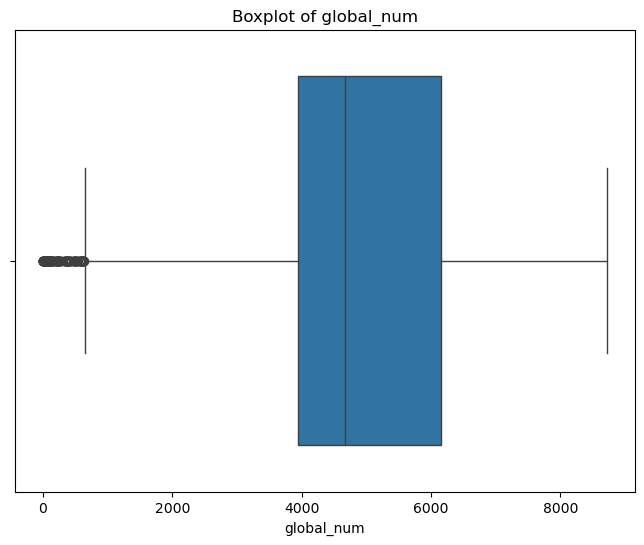

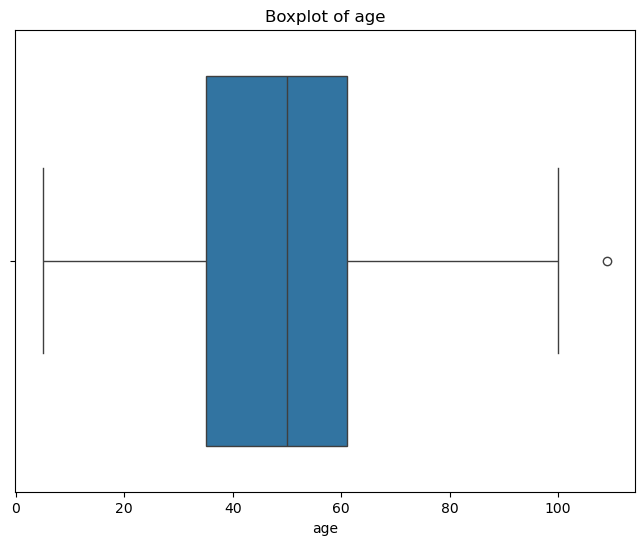

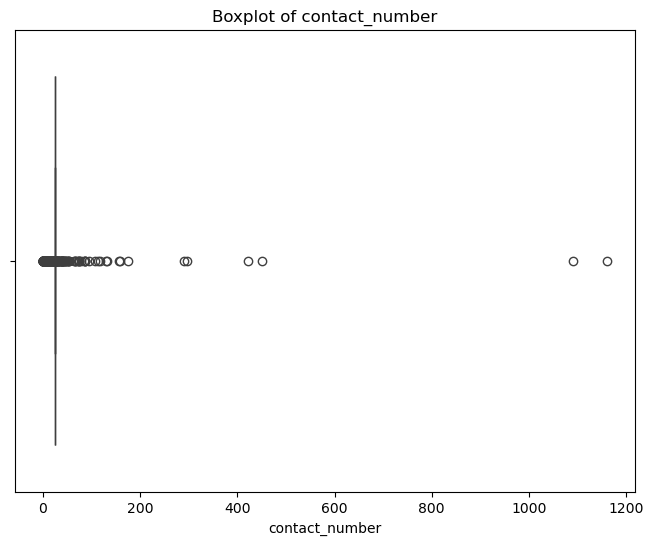

In [390]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

continuous_data = ['global_num', 'age', 'contact_number']

for var in continuous_data :
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[var])
    plt.title(f'Boxplot of {var}')
    plt.xlabel(var)
    plt.show()


**<font color='teal'> Create dummy features for object type features. </font>**

In [399]:
print(df.columns)

Index(['patient_id', 'global_num', 'sex', 'birth_year', 'age', 'country',
       'province', 'city', 'disease', 'infection_case', 'infection_order',
       'infected_by', 'contact_number', 'confirmed_date', 'deceased_date',
       'state'],
      dtype='object')


In [485]:
features = ['global_num', 'sex', 'birth_year', 'age', 'country',
       'province', 'city', 'disease', 'infection_case', 'infection_order',
       'infected_by', 'contact_number', 'confirmed_date', 'deceased_date',
       'state']

In [489]:
Model = df.dropna(subset=['state'])

Model[features] = ['global_num', 'sex', 'birth_year', 'age', 'country',
       'province', 'city', 'disease', 'infection_case', 'infection_order',
       'infected_by', 'contact_number', 'confirmed_date', 'deceased_date',
       'state']

X = Model[features]

y = Model.state

In [491]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
X = OneHotEncoder(handle_unknown='ignore', sparse_output = False).set_output(transform='pandas')
X = ohe.fit_transform(Model[features])







In [493]:
X = pd.get_dummies(X)

In [518]:
X

,global_num_global_num,sex_sex,birth_year_birth_year,age_age,country_country,province_province,city_city,disease_disease,infection_case_infection_case,infection_order_infection_order,infected_by_infected_by,contact_number_contact_number,confirmed_date_confirmed_date,deceased_date_deceased_date,state_state
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2213,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2214,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2215,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2216,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Split the data into test and train subsamples

In [496]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [521]:
print(X_train.isna().sum()) 

global_num_global_num              0
sex_sex                            0
birth_year_birth_year              0
age_age                            0
country_country                    0
province_province                  0
city_city                          0
disease_disease                    0
infection_case_infection_case      0
infection_order_infection_order    0
infected_by_infected_by            0
contact_number_contact_number      0
confirmed_date_confirmed_date      0
deceased_date_deceased_date        0
state_state                        0
dtype: int64


### Scale data to prep for model creation

In [523]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [525]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [572]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,0]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=1.000
Random Forest: f1-score=1.000


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [567]:
print(f"y_pred shape: {y_pred.shape}")


y_pred shape: (414,)


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [574]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[414]]
Normalized confusion matrix
[[1.]]


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


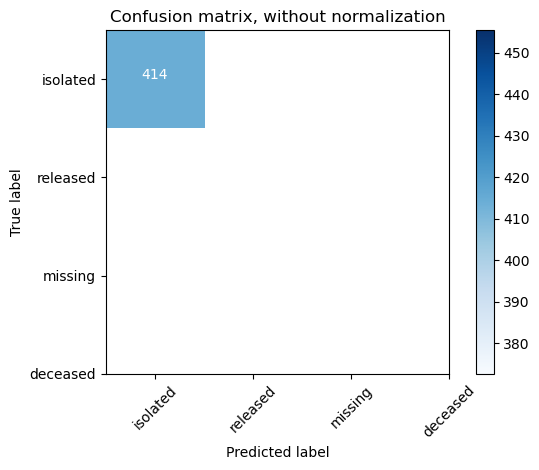

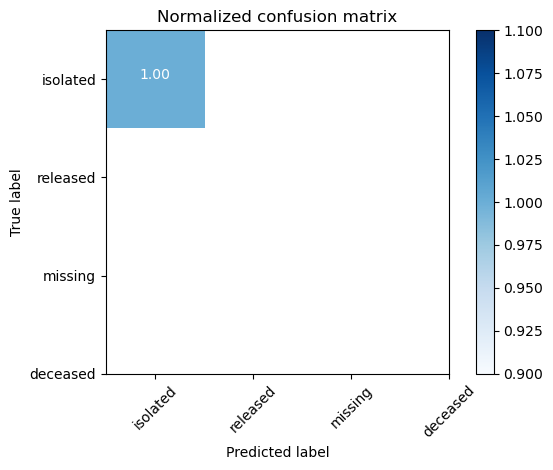

In [576]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

15


/var/folders/23/29dm_wdd3v56qd1vnzv031hm0000gn/T/ipykernel_17273/3557751883.py:3: RuntimeWarning: invalid value encountered in divide
  feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]


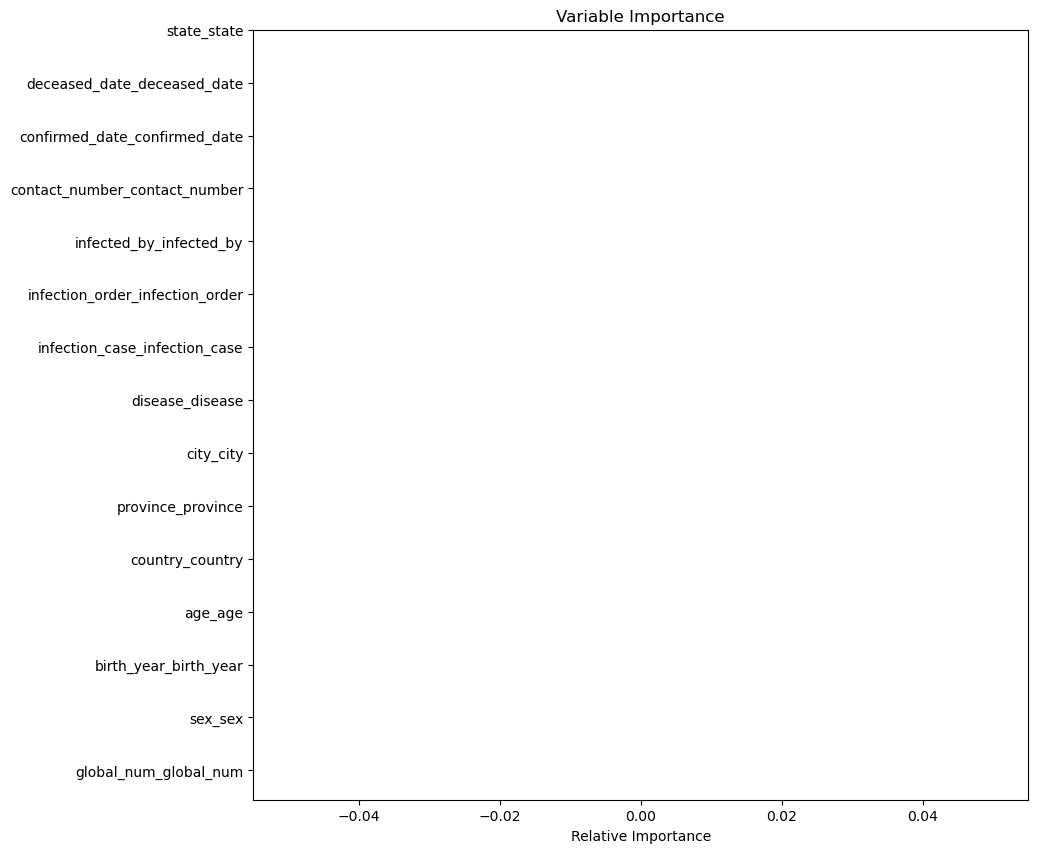

In [584]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])

plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.